# Use bayes net to detect breast cancer.

Written by filrLi@github, please cite if you use.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from graphviz import Digraph
import numpy as np
import pandas as pd
import copy as cp
from collections import OrderedDict as odict
from itertools import product, combinations
from tabulate import tabulate

Get some general ideas by inspecting the dataset.

In [3]:
data = pd.read_csv('bc 2.csv')
data.head()
for column in data.columns:
    data[column].value_counts()
    print('___________________________________')

,BreastDensity,Location,Age,BC,Mass,AD,Metastasis,MC,Size,Shape,FibrTissueDev,LymphNodes,SkinRetract,NippleDischarge,Spiculation,Margin
0,high,LolwOutQuad,35-49,No,No,No,no,No,<1cm,Other,No,no,No,No,No,Well-defined
1,medium,UpOutQuad,50-74,Invasive,Benign,No,yes,Yes,<1cm,Oval,No,yes,No,Yes,No,Well-defined
2,low,UpInQuad,50-74,Invasive,Benign,No,yes,No,1-3cm,Other,Yes,yes,Yes,No,Yes,Well-defined
3,medium,LowInQuad,>75,Invasive,Malign,No,yes,Yes,<1cm,Round,No,no,No,No,No,Ill-defined
4,high,LowInQuad,<35,No,Benign,No,no,No,>3cm,Oval,No,no,No,No,Yes,Ill-defined


medium    9982
high      6029
low       3989
Name: BreastDensity, dtype: int64

___________________________________


UpInQuad       5039
LolwOutQuad    5022
LowInQuad      5015
UpOutQuad      4924
Name: Location, dtype: int64

___________________________________


50-74    10005
35-49     4960
>75       2956
<35       2079
Name: Age, dtype: int64

___________________________________


No          12439
Invasive     4723
Insitu       2838
Name: BC, dtype: int64

___________________________________


No        12627
Malign     4137
Benign     3236
Name: Mass, dtype: int64

___________________________________


No     16374
Yes     3626
Name: AD, dtype: int64

___________________________________


no     15360
yes     4640
Name: Metastasis, dtype: int64

___________________________________


No     15981
Yes     4019
Name: MC, dtype: int64

___________________________________


<1cm     14150
1-3cm     3150
>3cm      2700
Name: Size, dtype: int64

___________________________________


Other        12806
Irregular     3238
Round         2547
Oval          1409
Name: Shape, dtype: int64

___________________________________


No     11578
Yes     8422
Name: FibrTissueDev, dtype: int64

___________________________________


no     14601
yes     5399
Name: LymphNodes, dtype: int64

___________________________________


No     13861
Yes     6139
Name: SkinRetract, dtype: int64

___________________________________


No     14012
Yes     5988
Name: NippleDischarge, dtype: int64

___________________________________


No     11992
Yes     8008
Name: Spiculation, dtype: int64

___________________________________


Well-defined    10313
Ill-defined      9687
Name: Margin, dtype: int64

___________________________________


## Create a function to visualize the net.

In [4]:
def showGraph(graph):
    dot = Digraph(comment='ICU Graph')
    dot.attr(overlap="False", splines="True")
    for v in graph:
        dot.node(str(v))
    for v in graph:
        for w in graph[v]:
            dot.edge(str(v), str(w))
    return dot

In [5]:
graph = {
    'BreastDensity': ['Mass'],
    'Location': ['BC'],
    'Age': ['BC'],
    'BC': ['Mass', 'AD', 'Metastasis', 'MC', 'SkinRetract', 'NippleDischarge'],
    'Mass': ['Shape', 'Size', 'Margin'],
    'AD': ['FibrTissueDev'],
    'Metastasis': ['LymphNodes'],
    'MC': [],
    'Size': [],
    'Shape': [],
    'FibrTissueDev': ['NippleDischarge', 'Spiculation', 'SkinRetract'],
    'LymphNodes': [],
    'SkinRetract': [],
    'NippleDischarge': [],
    'Spiculation': ['Margin'],
    'Margin': [],
}

'bayesNet.png'

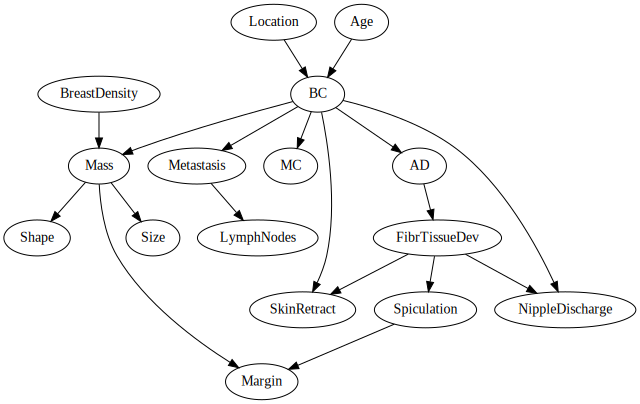

In [6]:
bayesNet = showGraph(graph)
bayesNet.format = 'png'
bayesNet.render('bayesNet')
bayesNet

## Task 1 – Efficient d-separation test
Algorithm:

Testing whether X and Y are d-separated by Z in a DAG G is equivalent to testing whether X and Y are disconnected in a new DAG G′, which is obtained by pruning DAG G as follows:
1. Delete any leaf node W from DAG G as long as W does not belong to X ∪ Y ∪ Z. This process is repeated until no more nodes can be deleted.
2. Delete all edges outgoing from nodes in Z.

Implement the efficient version of the d-separation algorithm in a function `d_separation(G,X,Y,Z)` that return a boolean: true if X is d-separated from Y given Z and false otherwise.


### Time complexity analysis
1. Pruning the graph cost $O(n^2)$
2. Checking whether two node are connected cost $O(n)$, check whether two sets of nodes are disconnected cost $O(n^2)$

So total cost is $O(n^2)$

'prunedGraph.png'

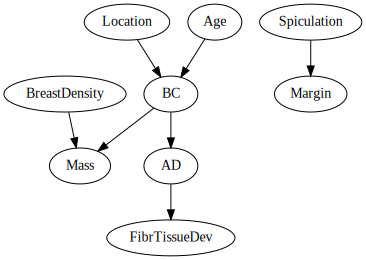

{'Location'}, {'Margin'} is d-separable given {'FibrTissueDev', 'Mass'}: True


In [7]:
def d_separation(G, X, Y, Z):
    pruned_G = prune(G, X, Y, Z)
    return not isConnected(pruned_G, X, Y)


def prune(G, X, Y, Z):
    newG = cp.copy(G)
    all_deleted = 0
    XUYUZ = X | Y | Z

    # delete any leaf node W from DAG G as long as W does not belong to X ∪ Y ∪ Z
    while not all_deleted:
        all_deleted = 1
        W = set()
        for node, children in newG.items():
            if node not in XUYUZ and not children:
                W.add(node)
                all_deleted = 0
        for leaf in W:
            newG.pop(leaf)
        # clear the child who have been deleted
        for node, children in newG.items():
            newG[node] = [_ for _ in children if _ not in W]

    # delete all edges outgoing from nodes in Z
    for node in Z:
        newG[node] = []
    return newG


def transposeGraph(G):
    GT = dict((v, []) for v in G)
    for v in G:
        for w in G[v]:
            if w in GT:
                GT[w].append(v)
            else:
                GT[w] = [v]
    return GT


def isConnected(G, X, Y):
    GT = transposeGraph(G)
    undirectG = cp.copy(G)
    for node in G:
        undirectG[node] += GT[node]
    
    spreadX = set()
    for x in X:
        spread(undirectG, x, spreadX)
    
    return any([_ for _ in Y if _ in spreadX])

def spread(G, node, visited):
    visited.add(node)
    for child in G[node]:
        if child not in visited:
            spread(G, child, visited)


#######################################
# Test code
#######################################

ng = prune(graph, {'Location'}, {'Margin'}, {'FibrTissueDev', 'Mass'})


prunedGraph = showGraph(ng)
prunedGraph.format = 'png'
prunedGraph.render('prunedGraph')
prunedGraph
print("{'Location'}, {'Margin'} is d-separable given {'FibrTissueDev', 'Mass'}:",
      d_separation(graph, {'Location'}, {'Margin'}, {'FibrTissueDev', 'Mass'}))

Some useful functions

In [8]:
def printFactor(f):
    table = list()
    for key, item in f['table'].items():
        k = list(key)
        k.append(item)
        table.append(k)
    dom = list(f['dom'])
    dom.append('Pr')
    print(tabulate(table, headers=dom, tablefmt='orgtbl'))

def prob(factor, *entry):
    return factor['table'][entry]

In [9]:
def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

Define the outcome space.

## Task 2 – Estimate Bayesian Network parameters from data

Estimating the parameters of a Bayesian Network is a relatively simple task if we have complete data. The file bc.csv has 20,000 complete instances, i.e., without missing values. The task is to estimate and store the conditional probability tables for each node of the graph. As we will see in more details in the Naive Bayes and Bayesian Network learning lectures, the Maximum Likelihood Estimate (MLE) for those probabilities are simply the empirical probabilities (counts) obtained from data.


Implement a function `learn_bayes_net(G, file, outcomeSpace, prob_tables)` that learns the parameters of the Bayesian Network G. This function should output a dictionary `prob_tables` with the all conditional probability tables (one for each node), as well as the `outcomeSpace` with the variables domain values.


**I implement Laplace smoothing when estamating the prob table for each variables.**

In [10]:
def learn_bayes_net(G, file, outcomeSpace={}, prob_tables=odict()):
    data = pd.read_csv(file)

    for column in data.columns:
        outcomeSpace[column] = tuple(data[column].unique())
    graphT = transposeGraph(G)
    for node, parents in graphT.items():
        prob_tables[node] = estProbTable(data, node, parents, outcomeSpace)
    return prob_tables, outcomeSpace


def estProbTable(data, var_name, parent_names, outcomeSpace):
    var_outcomes = outcomeSpace[var_name]
    var_outcomes_size = len(var_outcomes)
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]

    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()

    for i, parent_combination in enumerate(all_parent_combinations):
        cond_array = []
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name]) == var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])
                       ] = ((var_index & parent_index).sum()+1)/(parent_index.sum()+var_outcomes_size) #implementing smooth method

    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}

In [42]:
prob_tables, outcomeSpace = learn_bayes_net(graph, 'bc 2.csv')

#######################################
# Test code
#######################################
print('Outcome Space:')
outcomeSpace
print()
print('Example: Conditional distribution for random variable Margin')
printFactor(prob_tables['Margin'])

Outcome Space:


{'BreastDensity': ('high', 'medium', 'low'),
 'Location': ('LolwOutQuad', 'UpOutQuad', 'UpInQuad', 'LowInQuad'),
 'Age': ('35-49', '50-74', '>75', '<35'),
 'BC': ('No', 'Invasive', 'Insitu'),
 'Mass': ('No', 'Benign', 'Malign'),
 'AD': ('No', 'Yes'),
 'Metastasis': ('no', 'yes'),
 'MC': ('No', 'Yes'),
 'Size': ('<1cm', '1-3cm', '>3cm'),
 'Shape': ('Other', 'Oval', 'Round', 'Irregular'),
 'FibrTissueDev': ('No', 'Yes'),
 'LymphNodes': ('no', 'yes'),
 'SkinRetract': ('No', 'Yes'),
 'NippleDischarge': ('No', 'Yes'),
 'Spiculation': ('No', 'Yes'),
 'Margin': ('Well-defined', 'Ill-defined')}


Example: Conditional distribution for random variable Margin
| Mass   | Spiculation   | Margin       |          Pr |
|--------+---------------+--------------+-------------|
| No     | No            | Well-defined | 0.999873    |
| No     | No            | Ill-defined  | 0.000127405 |
| No     | Yes           | Well-defined | 0.000209118 |
| No     | Yes           | Ill-defined  | 0.999791    |
| Benign | No            | Well-defined | 0.747368    |
| Benign | No            | Ill-defined  | 0.252632    |
| Benign | Yes           | Well-defined | 0.357463    |
| Benign | Yes           | Ill-defined  | 0.642537    |
| Malign | No            | Well-defined | 0.206759    |
| Malign | No            | Ill-defined  | 0.793241    |
| Malign | Yes           | Well-defined | 0.0560254   |
| Malign | Yes           | Ill-defined  | 0.943975    |


We are working with a small Bayesian Network with 16 nodes. What will be the size of the joint distribution with all 16 variables?

**Answer:**

* The size of the joint distribution depends on the size of domain values of each node.
* which is 2654208

In [12]:
from functools import reduce
joint_distribution_size = reduce(lambda x, y: x*y, [len(_) for _ in outcomeSpace.values()])
print(joint_distribution_size)


2654208


## Task 3 – Sampling

To sample from the bayes network, first we need to topologically sort the graph, then based on the topological order, assign the value to each node in the network.

### Time complexity analysis

1. Topological sort is actually based on DFS, so the cost is $O(N)$
2. Sampling cost $O(N)$

So the total time complexity is $O(N)$

**What happens as you add more observed variables in the query in terms of accuracy and effective sample size?**

   *Answer: As I add more observed variables in the query, the size of effective samples will shrink because the evidences observed narrow the outcome space and the output will be more accurate.*


### 3.1 Topological sort

In [13]:
def topologicalSortUtil(G, node, visited, stack): 

    visited[node] = 1

    for child in G[node]: 
        if not visited[child]: 
            topologicalSortUtil(G, child, visited, stack) 

    stack.append(node) 

def topologicalSort(G): 
    visited = dict([(node, 0) for node in G.keys()])
    stack =[] 

    for node in G: 
        if not visited[node]: 
            topologicalSortUtil(G, node, visited, stack) 
    
    stack.reverse()
    return stack 

#######################################
# Test code
#######################################
topologicalOrder = topologicalSort(graph)

let's visualize the topological sort

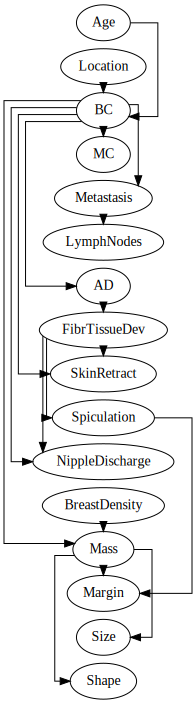

'tgraph.png'

In [14]:
def topologicalShow(G):
    dot = Digraph(engine="neato", comment='Topological sort')
    dot.attr(overlap="false", splines="ortho")
    i = 1
    s = topologicalSort(G)
    for v in reversed(s):
        dot.node(str(v), pos='0,'+ str(i)+'!')
        i = i + 1

    # Create edges
    for v in s:
        for w in graph[v]:
            dot.edge(str(v), str(w))
    return dot

tgraph = topologicalShow(graph)
tgraph
tgraph.format = 'png'
tgraph.render('tgraph')

### Sampling

In [15]:
def sampling(G, order, prob_tables, outcomeSpace):
    GT = transposeGraph(G)
    sample = dict()
    for node in order:
        parents_val = []
        for parent in GT[node]:
            parents_val.append(sample[parent])
        
        node_vars_distribution = dict()
        for node_outcome in outcomeSpace[node]:
            combination = parents_val + [node_outcome] 
            node_vars_distribution[node_outcome] = prob_tables[node]['table'][tuple(combination)]
            
        sample[node] = randomPickFrom(node_vars_distribution)
    
    return sample

def randomPickFrom(distribution):
    num = np.random.rand()
    cumulative_probability = 0.0 
    for val, val_probability in distribution.items(): 
        cumulative_probability += val_probability 
        if num < cumulative_probability:break 
    return val



#######################################
# Test code
#######################################
sample1 = sampling(graph, topologicalOrder, prob_tables, outcomeSpace)
pd.DataFrame(sample1, index=[0])

,Age,Location,BC,MC,Metastasis,LymphNodes,AD,FibrTissueDev,SkinRetract,Spiculation,NippleDischarge,BreastDensity,Mass,Margin,Size,Shape
0,50-74,LolwOutQuad,Invasive,Yes,yes,yes,Yes,Yes,Yes,Yes,Yes,medium,No,Ill-defined,<1cm,Other


Now, let's generate 1000 such samples and save them to 1000samples.csv

In [16]:
newSamples = dict([(node, []) for node in topologicalOrder])
for i in range(1000):
    sample = sampling(graph, topologicalOrder, prob_tables, outcomeSpace)
    for node in topologicalOrder:
        newSamples[node].append(sample[node])
newSampleDF = pd.DataFrame(newSamples)
newSampleDF
newSampleDF.to_csv("1000samples.csv",index=False,sep=',')

,Age,Location,BC,MC,Metastasis,LymphNodes,AD,FibrTissueDev,SkinRetract,Spiculation,NippleDischarge,BreastDensity,Mass,Margin,Size,Shape
0,50-74,UpOutQuad,Invasive,Yes,yes,no,Yes,Yes,Yes,No,Yes,medium,No,Well-defined,<1cm,Other
1,<35,LolwOutQuad,Invasive,Yes,no,no,No,Yes,No,Yes,Yes,low,Malign,Ill-defined,<1cm,Oval
2,50-74,UpInQuad,No,No,no,no,No,No,No,Yes,No,high,No,Ill-defined,<1cm,Other
3,50-74,UpInQuad,Invasive,Yes,yes,yes,Yes,Yes,No,Yes,Yes,low,Malign,Ill-defined,<1cm,Irregular
4,>75,UpInQuad,No,No,no,no,No,No,No,No,No,medium,No,Well-defined,<1cm,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,<35,LolwOutQuad,No,No,no,no,No,No,No,No,No,low,No,Well-defined,<1cm,Other
996,35-49,UpInQuad,No,No,no,no,No,No,No,No,No,high,No,Well-defined,<1cm,Other
997,50-74,UpInQuad,No,No,no,no,No,No,Yes,Yes,No,medium,No,Ill-defined,<1cm,Other
998,50-74,UpInQuad,Insitu,No,yes,yes,Yes,No,No,No,No,medium,No,Well-defined,<1cm,Other


## Task 4 – Classification

This particular Bayesian Network has a variable that plays a central role in the analysis. The variable BC
(Brest Cancer) can assume the values No, Invasive and InSitu. Accurately identifying its correct value
would lead to an automatic system that could help in early breast cancer diagnosis.

Use the Bayesian Network to classify cases of the dataset. Propose an experimental setup to estimate the
classification error.

Compare the classification error of the Bayesian Network with your favourite Machine
Learning classifier.

### 4.1 Train-test split

In [37]:
from sklearn.model_selection import train_test_split

X, y = data[data.columns.difference(['BC'])], data['BC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
train = X_train.copy()
train['BC'] = y_train.copy()

### 4.2 Fit the bayes net

In [38]:
def fit_bayes_net(G, data, outcomeSpace, prob_tables=odict()):
    graphT = transposeGraph(G)
    for node, parents in graphT.items():
        prob_tables[node] = estProbTable(data, node, parents, outcomeSpace)
    return prob_tables


#######################################
# Test code
#######################################
train_prob_tables = fit_bayes_net(graph, train, outcomeSpace)
printFactor(train_prob_tables['Margin'])

| Mass   | Spiculation   | Margin       |          Pr |
|--------+---------------+--------------+-------------|
| No     | No            | Well-defined | 0.99984     |
| No     | No            | Ill-defined  | 0.000160205 |
| No     | Yes           | Well-defined | 0.000260146 |
| No     | Yes           | Ill-defined  | 0.99974     |
| Benign | No            | Well-defined | 0.752646    |
| Benign | No            | Ill-defined  | 0.247354    |
| Benign | Yes           | Well-defined | 0.358002    |
| Benign | Yes           | Ill-defined  | 0.641998    |
| Malign | No            | Well-defined | 0.20762     |
| Malign | No            | Ill-defined  | 0.79238     |
| Malign | Yes           | Well-defined | 0.0538765   |
| Malign | Yes           | Ill-defined  | 0.946124    |


### 4.3 Predict BC given evidences

In [39]:
def predict(prob_tables, X):
    result = {'predict':[]}
    for i in range(len(X)):
        result['predict'].append(singlePredict(prob_tables, X.iloc[i]))
    result = pd.DataFrame(result)
    return result

def singlePredict(prob_tables, x):
    outSpace = dict([(node, (x[node],)) for node in x.index])
    outSpace['BC'] = ('No', 'Invasive', 'Insitu')
    joint_d = p_joint(outSpace, prob_tables)
    
    for node in x.index:
        joint_d = marginalize(joint_d, node, outSpace)
    
    
    return max(joint_d['table'], key = joint_d['table'].get)[0]


def p_joint(outcomeSpace, prob_tables):
    nodes = list(outcomeSpace.keys())
    result = prob_tables[nodes[0]]
    for node in nodes[1:]:
        result = join(result, prob_tables[node], outcomeSpace)
    return result


def join(f1, f2, outcomeSpace):
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    table = list()
    
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        p1 = prob(f1, *f1_entry) 
        p2 = prob(f2, *f2_entry)
        
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}      
    


def marginalize(f, var, outcomeSpace):
    new_dom = list(f['dom'])
    
    new_dom.remove(var)
    table = list()
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0
        for val in outcomeSpace[var]:
            entriesList = list(entries)
            entriesList.insert(f['dom'].index(var), val)
            

            p = prob(f, *tuple(entriesList))
            s = s + p
            
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}


#######################################
# Test code
#######################################
y_pred = predict(train_prob_tables, X_test)
y_pred

,predict
0,No
1,Insitu
2,No
3,No
4,Invasive
...,...
3995,No
3996,Invasive
3997,No
3998,Invasive


Let's see how accurate our model is.

In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.91475

In [36]:
def score(data=data, test_ratio=0.2, graph=graph, outcomeSpace=outcomeSpace, seed=17):
    X, y = data[data.columns.difference(['BC'])], data['BC']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=seed)
    train = X_train.copy()
    train['BC'] = y_train.copy()
    
    train_prob_tables = fit_bayes_net(graph, train, outcomeSpace)
    y_pred = predict(train_prob_tables, X_test)
    return accuracy_score(y_test, y_pred)

score(test_ratio = 0.2)

0.91475

### Compare with other classification model

Let's try Gaussian Naive Bayes and KNN

First, we need to replace text with integer.

In [22]:
convert = dict()
for node, vals in outcomeSpace.items():
    convert[node] = {}
    for i, val in enumerate(vals):
        convert[node][val] = i

convertedData = data.copy()
for node, convert_dict in convert.items():
    convertedData[node].replace(convert_dict, inplace=True)
convertedData.head()

,BreastDensity,Location,Age,BC,Mass,AD,Metastasis,MC,Size,Shape,FibrTissueDev,LymphNodes,SkinRetract,NippleDischarge,Spiculation,Margin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,0,1,0,1,0,1,0,0
2,2,2,1,1,1,0,1,0,1,0,1,1,1,0,1,0
3,1,3,2,1,2,0,1,1,0,2,0,0,0,0,0,1
4,0,3,3,0,1,0,0,0,2,1,0,0,0,0,1,1


In [23]:
# Train test split
cX, cy = convertedData[convertedData.columns.difference(['BC'])], convertedData['BC']
cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=0.2, random_state=42)

Gaussian Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
cy_pred = gnb.fit(cX_train, cy_train).predict(cX_test)
print('The accuaracy of GaussianNB: ', accuracy_score(cy_test, cy_pred))

The accuaracy of GaussianNB:  0.89475


KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
cy_pred = neigh.fit(cX_train, cy_train).predict(cX_test)
print('The accuaracy of KNN: ', accuracy_score(cy_test, cy_pred))

The accuaracy of KNN:  0.87225


In [26]:
import matplotlib.pyplot as plt

BN, NB, KNN = [], [], []
for test_size in np.arange(0.1, 1, 0.1):
    #Record Bayes net results
    BN.append(score(test_ratio=test_size))
    
    cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size=test_size, random_state=17)
    #Record GaussianNB results
    cy_pred = gnb.fit(cX_train, cy_train).predict(cX_test)
    NB.append(accuracy_score(cy_test, cy_pred))
    
    #Record KNN results
    cy_pred = neigh.fit(cX_train, cy_train).predict(cX_test)
    KNN.append(accuracy_score(cy_test, cy_pred))


Text(0.5, 0, 'test size')

Text(0, 0.5, 'accuaracy')

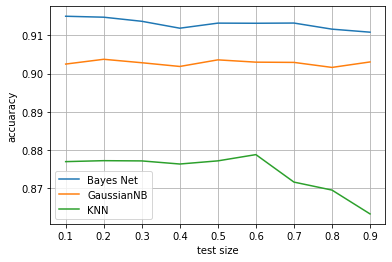

In [41]:
x = np.arange(0.1, 1, 0.1)
l1, = plt.plot(x, BN, label='Bayes Net')
l2, = plt.plot(x, NB, label='GaussianNB')
l3, = plt.plot(x, KNN, label='KNN')
plt.grid()
plt.legend()
plt.xlabel('test size')
plt.ylabel('accuaracy')
plt.savefig('compare.png', dpi=200)
plt.show()


**From the result, we can see that our Bayes net is a little better than Gaussian Naive Bayes and KNN models.**

And the test size doesn't affect the accuracy of Bayes Net and GaussianNB very much.